**Name:** Veljko Kovac

# Linear Dimensionality Reduction and Face Recognition


In [1]:
# %matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
random.seed(100)

## 1. Loading Data and Pre-processing


In [2]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show an example:

(64, 64)


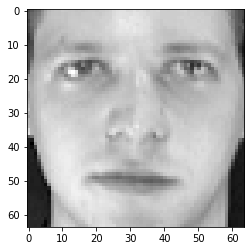

In [3]:
print(img[0].shape)
plt.imshow(img[0], cmap='gray', interpolation='nearest')
plt.show()

Showing all images

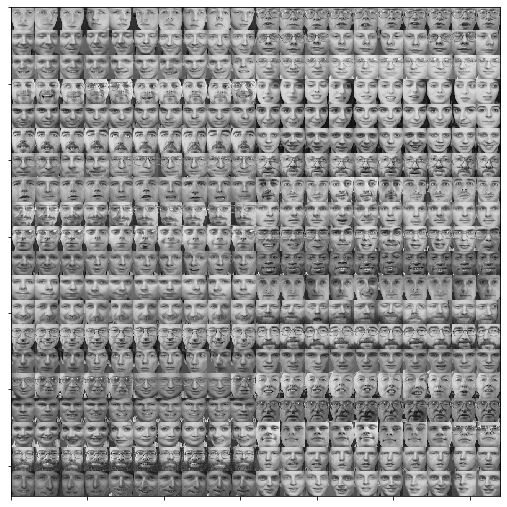

In [4]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. The class labels are in vector `Y`. Now we split the data into training and testing sets.

In [5]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


## 2. Principal Component Analysis - PCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use PCA to reduce the dimension first and then use the PCA weights as the representation for each image.  Run PCA on the data using 9 principal components.

In [6]:
pca = decomposition.PCA(n_components=9)
newTrainX = pca.fit_transform(trainX)
newTestX = pca.transform(testX)

In [7]:
testX.shape

(80, 4096)

The below function will plot the basis vectors of PCA. Run the next 2 cells to view the PCs.

In [8]:
def plot_basis(model, imgsize):
    cname = model.__class__.__name__
    print(cname)
    if  cname == 'LDA':
        KK = model.n_components
        comps = model.coef_
        mn = None
    elif cname == 'PCA':
        KK = model.n_components_
        comps = model.components_
        mn = model.mean_
    elif cname == 'TruncatedSVD':
        KK = model.n_components
        comps = model.components_
        mn = None
    K = KK
    if mn is not None:
        K += 1        
    nr = ceil(K/5.0)
    sind = 1

    #vmin = comps.flatten().min()
    #vmax = comps.flatten().max()
    
    # plot the mean
    pcfig = plt.figure(figsize=(8, nr*2))
    if mn is not None:
        plt.subplot(nr, 5, sind)
        plt.imshow(mn.reshape(imgsize), interpolation='nearest')
        plt.title("mean")
        plt.gray()
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])    
        sind += 1
    # plot the components
    for j in range(0,KK):
        plt.subplot(nr,5,sind)
        v = comps[j,:]            
        I = v.reshape(imgsize)
        plt.imshow(I, interpolation='nearest')
        plt.gray()
        plt.title("basis " + str(j+1))
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        sind += 1

PCA


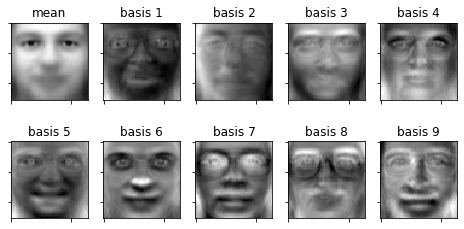

In [9]:
plot_basis(pca, imgsize)

### Face Recognition
Using the calculated PCA representation as the new set of inputs, we will train a logistic classifier in order to perform the face recognition.

In [10]:
lrcv = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 20), cv=5, n_jobs=-1, multi_class='auto', max_iter=300)
lrcv.fit(newTrainX, trainY)
predict = lrcv.predict(newTestX)


In [11]:
score = metrics.accuracy_score(predict, testY)
print(f"The accuracy of LogisticRegressionCV is {score}")

The accuracy of LogisticRegressionCV is 0.75


### Finding the best number of components


In [12]:
ns=[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]

params = {'C': logspace(-6,3,15)}
trainacc = []
testacc = []
print("ns: train score, test score")
for n in ns:
    pca = decomposition.PCA(n_components=n)
    pca_trainX = pca.fit_transform(trainX)
    pca_testX = pca.transform(testX)

    lmcv = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 20), cv=5, n_jobs=-1, multi_class='auto', max_iter=1000)
    lmcv.fit(pca_trainX, trainY)
    
    train_predict = lmcv.predict(pca_trainX) 
    test_predict = lmcv.predict(pca_testX)

    train_score = metrics.accuracy_score(train_predict, trainY)
    trainacc.append(train_score)
    test_score = metrics.accuracy_score(test_predict, testY)
    testacc.append(test_score)

    print(f"{n} : {train_score}, {test_score}")

ns: train score, test score
1 : 0.14375, 0.1
5 : 0.853125, 0.55
10 : 0.9875, 0.825
15 : 1.0, 0.9
20 : 1.0, 0.9125
25 : 1.0, 0.9375
30 : 1.0, 0.95
35 : 1.0, 0.95
40 : 1.0, 0.95
45 : 1.0, 0.95
50 : 1.0, 0.9375
55 : 1.0, 0.9375
60 : 1.0, 0.95
65 : 1.0, 0.9375
70 : 1.0, 0.9375
75 : 1.0, 0.925
80 : 1.0, 0.925
85 : 1.0, 0.9375
90 : 1.0, 0.9375


Text(0, 0.5, 'accuracy')

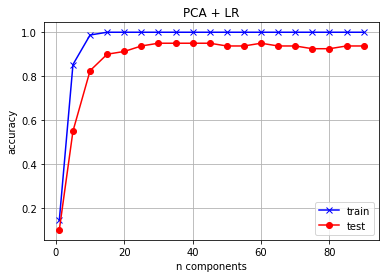

In [13]:
plt.plot(ns, trainacc, 'bx-', label='train')
plt.plot(ns, testacc, 'ro-', label='test')
plt.title("PCA + LR")
plt.legend(loc=0)
plt.grid(True); plt.xlabel('n components'); plt.ylabel('accuracy')

Plot the basis vectors of PCA with 20 components

PCA


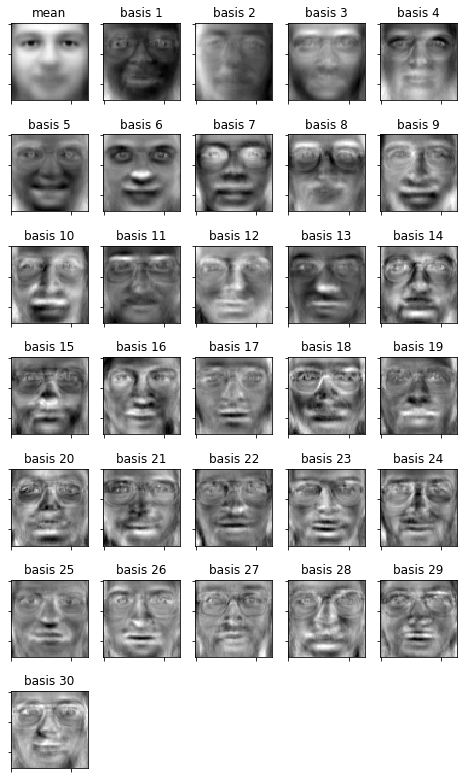

In [14]:
pca = decomposition.PCA(n_components=30)
pca_trainX = pca.fit_transform(trainX)
pca_testX = pca.transform(testX)

lmcv = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 20), cv=5, n_jobs=-1, multi_class='auto', max_iter=1000)
lmcv.fit(pca_trainX, trainY)

plot_basis(pca, imgsize)

# 3. Linear Dimensionality Reduction - SVD

Now we will repeat the experiment using non-negative matrix factorization instead of PCA. Perform SVD with 9 components and visualize the basis images.

TruncatedSVD


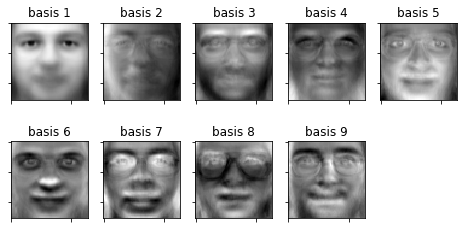

In [15]:
nmf = decomposition.TruncatedSVD(n_components=9)
new_trainX = nmf.fit_transform(trainX)
new_testX = nmf.transform(testX)

plot_basis(nmf, imgsize)

### Finding the best number of components

In [16]:
ns=[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]

params = {'C': logspace(-6,3,15)}
trainacc = []
testacc = []
for n in ns:
    nmf = decomposition.PCA(n_components=n)
    nmf_trainX = nmf.fit_transform(trainX)
    nmf_testX = nmf.transform(testX)

    lmcv = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 20), cv=5, n_jobs=-1, multi_class='auto', max_iter=1000)
    lmcv.fit(nmf_trainX, trainY)
    
    train_predict = lmcv.predict(nmf_trainX) 
    test_predict = lmcv.predict(nmf_testX)

    train_score = metrics.accuracy_score(train_predict, trainY)
    trainacc.append(train_score)
    test_score = metrics.accuracy_score(test_predict, testY)
    testacc.append(test_score)

    print(f"{n} : {train_score}, {test_score}")


1 : 0.14375, 0.1
5 : 0.853125, 0.55
10 : 0.9875, 0.825
15 : 1.0, 0.9
20 : 1.0, 0.9125
25 : 1.0, 0.9375
30 : 1.0, 0.95
35 : 1.0, 0.95
40 : 1.0, 0.95
45 : 1.0, 0.95
50 : 1.0, 0.9375
55 : 1.0, 0.9375
60 : 1.0, 0.95
65 : 1.0, 0.9375
70 : 1.0, 0.925
75 : 1.0, 0.9375
80 : 1.0, 0.9375
85 : 1.0, 0.9375
90 : 1.0, 0.9375


Text(0, 0.5, 'accuracy')

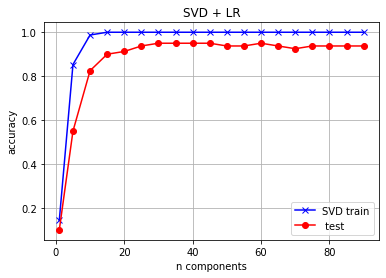

In [17]:
plt.plot(ns, trainacc, 'bx-', label='SVD train')
plt.plot(ns, testacc, 'ro-', label=' test')
plt.title("SVD + LR")
plt.legend(loc=0)
plt.grid(True); plt.xlabel('n components'); plt.ylabel('accuracy')

Plot the basis vectors of PCA with 35 components

PCA


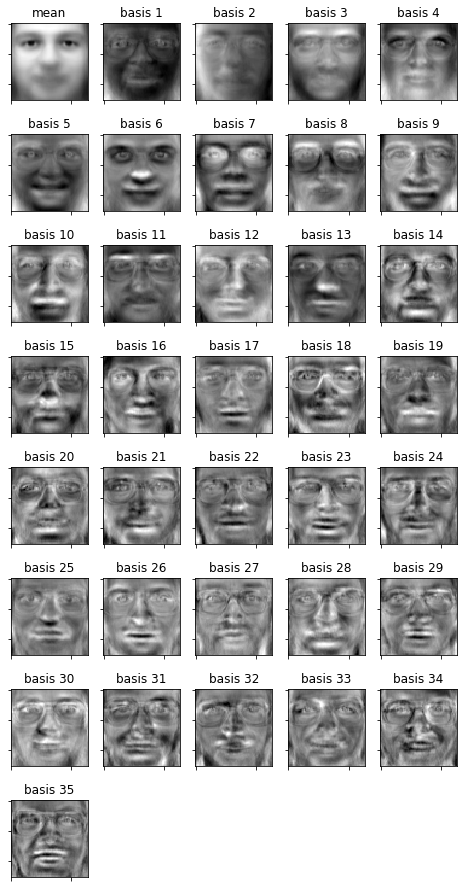

In [18]:
pca = decomposition.PCA(n_components=35)
pca_trainX = pca.fit_transform(trainX)
pca_testX = pca.transform(testX)

lmcv = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 20), cv=5, n_jobs=-1, multi_class='auto', max_iter=1000)
lmcv.fit(pca_trainX, trainY)

plot_basis(pca, imgsize)